### 1. Introduction

### 2. Data Understanding

2.1 Import Library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pymongo import MongoClient
from imblearn.over_sampling import SMOTE
import joblib

- Read Dataset

In [4]:
diabetes_dataset = pd.read_csv('diabetes.csv')
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


-  Insert Dataset ke MongoDB

In [3]:
client = MongoClient("mongodb://localhost:27017/")
db = client["diabetes_fix"]             
collection = db["data_diabetes"]

- convert t dictionary and insert to mongodb

In [4]:
data_dict = diabetes_dataset.to_dict("records")
collection.insert_many(data_dict)
print(f"Inserted {len(data_dict)} records into MongoDB.")

Inserted 768 records into MongoDB.


- Load Dataset dari MongoDB

In [5]:
# Ambil kembali data dari MongoDB
data = pd.DataFrame(list(collection.find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 3. Data Understanding

In [5]:
# Ukuran dataset
print("\n=== Ukuran Dataset ===")
print("Jumlah baris dan kolom:", diabetes_dataset.shape)

# Info tipe data
print("\n=== Info Dataset ===")
print(diabetes_dataset.info())

# Tipe data per kolom
print("\n=== Tipe Data per Kolom ===")
print(diabetes_dataset.dtypes)

# Statistik deskriptif lengkap
print("\n=== Statistik Deskriptif ===")
print(diabetes_dataset.describe(include='all').to_string())  # Menghindari pemotongan output

# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())

# Cek duplikasi
print("\n=== Cek Duplikasi ===")
print("Jumlah duplikat:", diabetes_dataset.duplicated().sum())


=== Ukuran Dataset ===
Jumlah baris dan kolom: (768, 9)

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Tipe Data per Kolom ===
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness      

In [ ]:
# Statistik deskriptif lengkap
print("\n=== Statistik Deskriptif ===")
print(diabetes_dataset.describe(include='all').to_string())  # Menghindari pemotongan output


=== Statistik Deskriptif ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction         Age     Outcome
count   768.000000  768.000000     768.000000     768.000000  768.000000  768.000000                768.000000  768.000000  768.000000
mean      3.845052  120.894531      69.105469      20.536458   79.799479   31.992578                  0.471876   33.240885    0.348958
std       3.369578   31.972618      19.355807      15.952218  115.244002    7.884160                  0.331329   11.760232    0.476951
min       0.000000    0.000000       0.000000       0.000000    0.000000    0.000000                  0.078000   21.000000    0.000000
25%       1.000000   99.000000      62.000000       0.000000    0.000000   27.300000                  0.243750   24.000000    0.000000
50%       3.000000  117.000000      72.000000      23.000000   30.500000   32.000000                  0.372500   29.000000    0.000000
75%       6.000000  140.2

### 4. Data Cleaning

In [8]:
# Handle missing values (encoded as 0)
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_dataset[zero_features] = diabetes_dataset[zero_features].replace(0, np.nan)

# Fill missing values with median
for feature in zero_features:
    diabetes_dataset[feature].fillna(diabetes_dataset[feature].median(), inplace=True)

# Remove duplicates
diabetes_dataset.drop_duplicates(inplace=True)

# Handle outliers using IQR for all numerical features
numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                     'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for feature in numerical_features:
    Q1 = diabetes_dataset[feature].quantile(0.25)
    Q3 = diabetes_dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    diabetes_dataset = diabetes_dataset[(diabetes_dataset[feature] >= lower_bound) & 
                       (diabetes_dataset[feature] <= upper_bound)]

print("Data after cleaning:", diabetes_dataset.shape)

Data after cleaning: (332, 9)


C:\Users\Mega Global\AppData\Local\Temp\ipykernel_13468\3965926827.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_dataset[feature].fillna(diabetes_dataset[feature].median(), inplace=True)
C:\Users\Mega Global\AppData\Local\Temp\ipykernel_13468\3965926827.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

Feature Engineering

In [11]:
# Create new features
diabetes_dataset['Glucose_BMI'] = diabetes_dataset['Glucose'] / diabetes_dataset['BMI']
diabetes_dataset['Age_Glucose'] = diabetes_dataset['Age'] * diabetes_dataset['Glucose']
diabetes_dataset['BP_Glucose'] = diabetes_dataset['BloodPressure'] * diabetes_dataset['Glucose']

# Split features and target
X = diabetes_dataset.drop('Outcome', axis=1)
y = diabetes_dataset['Outcome']

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_features)

print("Selected Features:", list(selected_features))

Selected Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_BMI', 'Age_Glucose', 'BP_Glucose']


c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### 5. Data Preprocessing

In [13]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=y)

# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

### 5. Data Transformation

5.1 Normalisasi Kolom Numerik

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Pisahkan kolom fitur dan target
X = data.drop("Outcome", axis=1)  # fitur
y = data["Outcome"]  # target

# Normalisasi fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Konversi kembali ke DataFrame dengan kolom fitur yang sudah dinormalisasi
X = pd.DataFrame(X_scaled, columns=X.columns)

# Menambahkan fitur baru: rasio Glucose dan BMI
X["Glucose_to_BMI"] = data["Glucose"] / (data["BMI"] + 1e-5)  # Menambahkan epsilon untuk hindari div/0

# Cek hasil
print("=== Ukuran Dataset ===")
print("Jumlah baris dan kolom:", X.shape)

print("\n=== Info Dataset ===")
print(X.info())

print("\n=== Statistik Deskriptif ===")
print(X.describe())

print("\n=== Tipe Data per Kolom ===")
print(X.dtypes)

print("\n=== Cek Duplikasi ===")
print("Jumlah duplikat:", X.duplicated().sum())

NameError: name 'data' is not defined

### 6. Simpan Data ke Excel

In [14]:
data.to_csv("diabetes_prepared.csv", index=False)

NameError: name 'data' is not defined

### 7.Exploratory Data Analysis / EDA

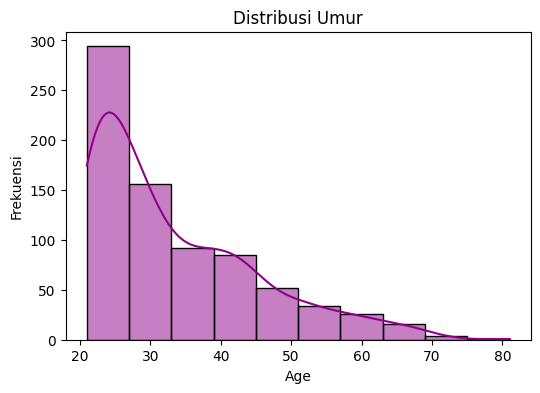

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='Age', bins=10, kde=True, color='#91008a')

plt.title('Distribusi Umur')
plt.xlabel('Age')
plt.ylabel('Frekuensi')
plt.show()

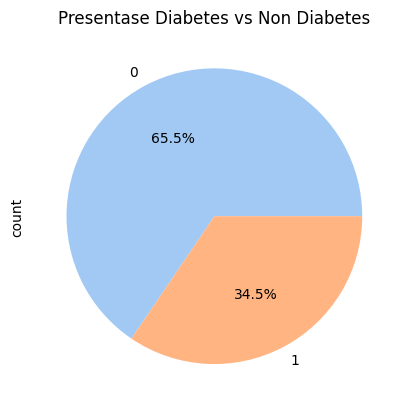

In [14]:
sns.set_palette('pastel')
data['Outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Presentase Diabetes vs Non Diabetes')
plt.show()

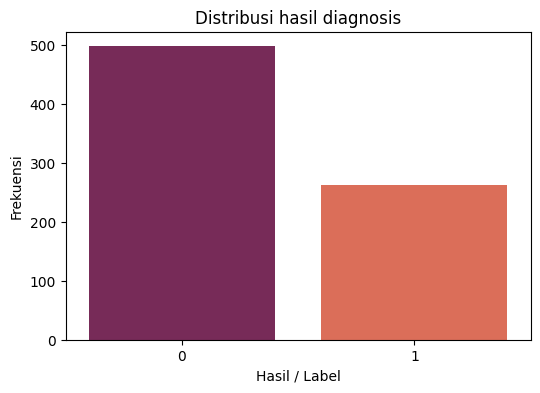

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Outcome', hue='Outcome', palette='rocket', legend=False)

plt.title('Distribusi hasil diagnosis')
plt.xlabel('Hasil / Label')
plt.ylabel('Frekuensi')
plt.show()

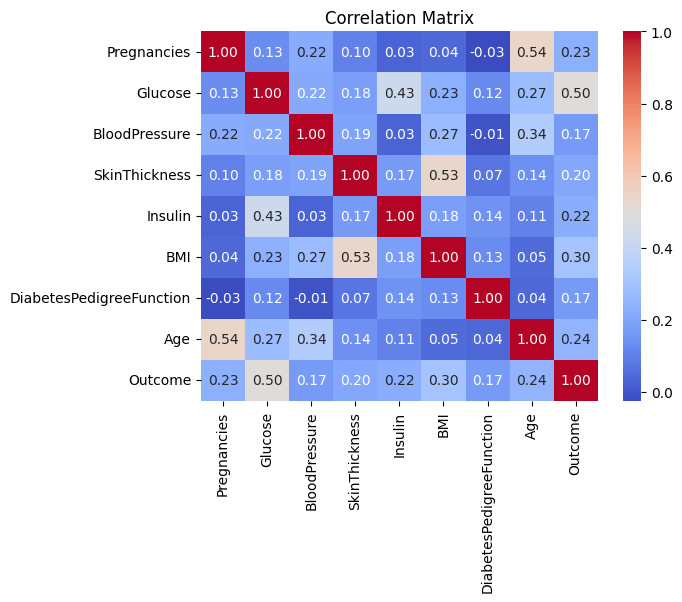

In [16]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

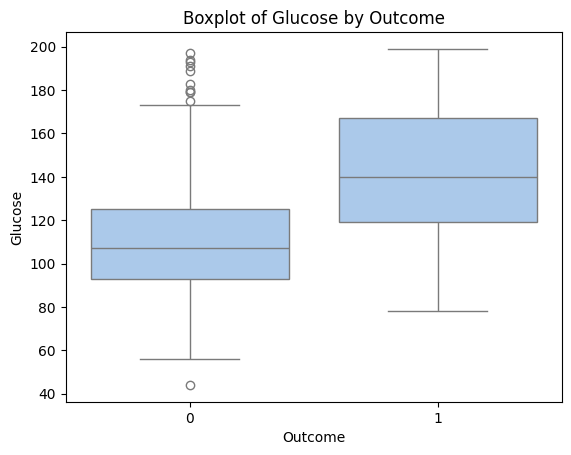

In [17]:
sns.boxplot(x="Outcome", y="Glucose", data=data)
plt.title("Boxplot of Glucose by Outcome")
plt.show()

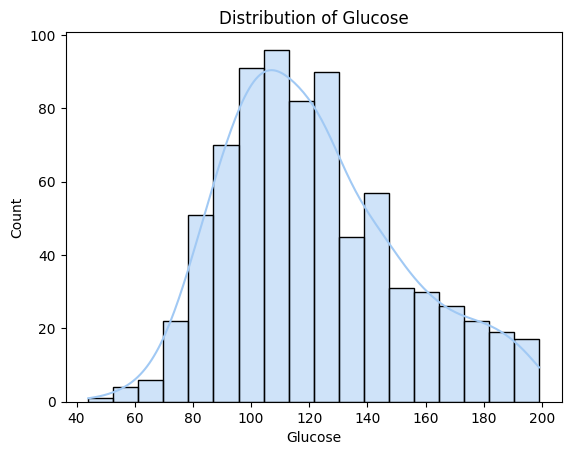

In [18]:
sns.histplot(data["Glucose"], kde=True)
plt.title("Distribution of Glucose")
plt.show()

In [19]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns[:-1], 1): 
    plt.subplot(3, 3, i)
    sns.kdeplot(data=df, x=column, hue="Outcome", common_norm=False, fill=True)
    plt.title(f'{column} berdasarkan Outcome')
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

<Figure size 2000x1500 with 0 Axes>

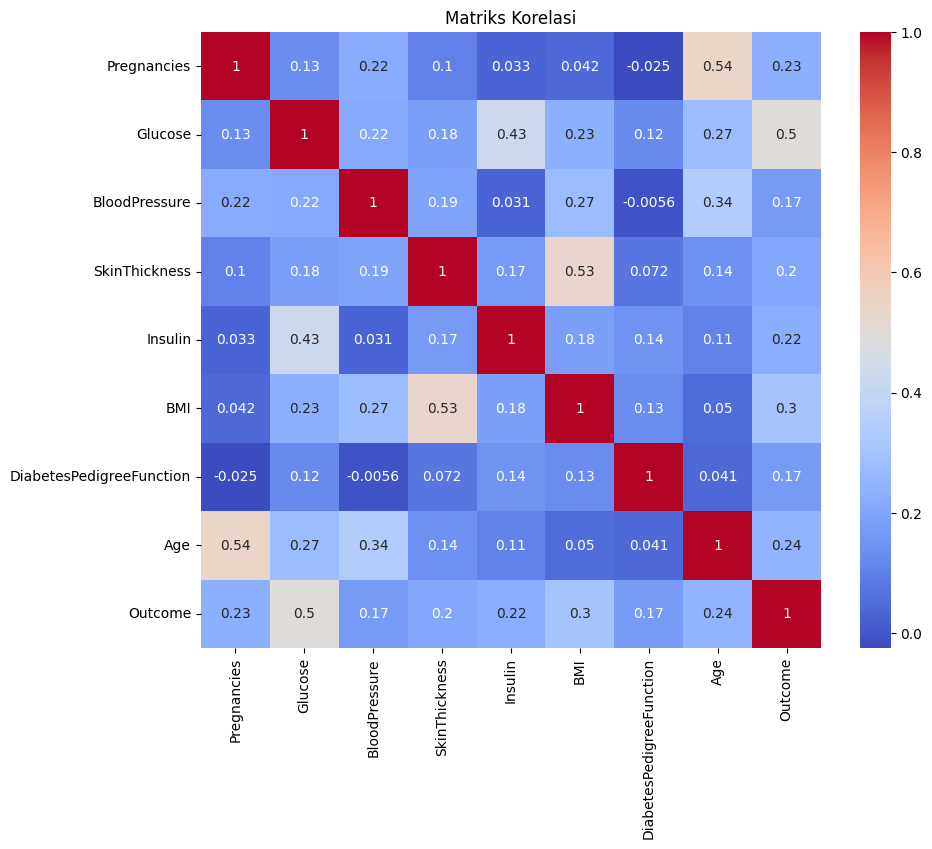

In [23]:
# Korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Matriks Korelasi")
plt.show()

## 8. Modeling - SVM 

 Split Data

In [15]:
# Parameter grid
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly'],
    'class_weight': [None, 'balanced']
}

# GridSearchCV
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, 
                         scoring='accuracy', verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best model
best_svm = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Cross-validation
cv_scores = cross_val_score(best_svm, X_resampled, y_resampled, 
                          cv=5, scoring='accuracy')
print(f"CV Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best Parameters: {'C': 1, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf'}
CV Accuracy: 0.84 ± 0.10


In [27]:
print(pd.DataFrame(X_train).isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Glucose_to_BMI              5
dtype: int64


In [28]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Bisa juga 'median', 'most_frequent', atau 'constant'
X_train = imputer.fit_transform(X_train)

Balancing Data dengan SMOTE

In [29]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

Scaling dengan StandardScaler

In [30]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Hyperparameter Tuning SVM dengan GridSearchCV

In [31]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_resampled_scaled, y_resampled)

print("Model terbaik:", grid.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01,

In [32]:
y_pred = grid.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Diabetes", "Diabetes"], yticklabels=["Non-Diabetes", "Diabetes"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix SVM (GridSearch + SMOTE + Scaling)")
plt.show()


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

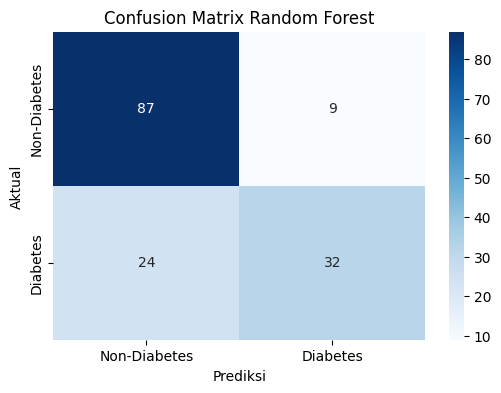

In [33]:
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetes', 'Diabetes'], yticklabels=['Non-Diabetes', 'Diabetes'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Random Forest")
plt.show()

In [34]:
# 1. Imputasi data jika ada nilai kosong
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# 2. Menyeimbangkan data dengan SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 3. Membuat model SVM
from sklearn import svm
classifier = svm.SVC(kernel='linear')
classifier.fit(X_resampled, y_resampled)


SVC(kernel='linear')